In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-traffic-violation/Indian_Traffic_Violations.csv


*Note: The author of this notebook attempted to perform regression on this dataset to some rather unflattering results!*

## **Introduction**

India’s roads pulse with diverse traffic dynamics, where violations ranging from over-speeding to drunk driving shape enforcement and safety challenges. This project analyzes a dataset of 4,000 traffic violation records to uncover natural groupings within this complexity. The dataset offers a rich canvas for unsupervised learning as it spans 27 features—numerical attributes like Speed_Excess and Alcohol_Level, and categorical variables like Violation_Type and Location. Unlike supervised approaches that predict outcomes like fines (a challenge met with limited success in prior work, you can check it out here: https://www.kaggle.com/code/calebboen/indian-traffic-violations-regression), clustering seeks to reveal inherent patterns without a predefined target. By applying techniques such as K-Means and DBSCAN, paired with dimensionality reduction via PCA and t-SNE, this analysis aims to segment violations into meaningful clusters—perhaps by severity, behavior, or region. Completed for my portfolio, this effort showcases my ability to explore and interpret complex datasets, offering insights that could guide traffic policy or enforcement strategies in an Indian context.

**Objective***
The goal of this project is to identify and characterize clusters of traffic violations using key features (e.g., Violation_Type, Speed_Excess, Alcohol_Level, Location), leveraging unsupervised learning methods to reveal structural patterns and enhance data understanding.

**Approach**

1. **EDA:** Explore distributions and relationships to inform feature selection.
2. **Preprocessing:** Standardize 6 core features for clustering compatibility.
3. **Clustering:** Apply K-Means (with elbow plot) and DBSCAN to group violations.
4. **Dimensionality Reduction:** Use PCA and t-SNE to visualize clusters, addressing variance retention challenges.

## **Data Loading/Cleaning**

In [49]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

In [50]:
# load data
df = pd.read_csv('/kaggle/input/indian-traffic-violation/Indian_Traffic_Violations.csv')
df.head()

,Violation_ID,Violation_Type,Fine_Amount,Location,Date,Time,Vehicle_Type,Vehicle_Color,Vehicle_Model_Year,Registration_State,...,Speed_Limit,Recorded_Speed,Alcohol_Level,Breathalyzer_Result,Towed,Fine_Paid,Payment_Method,Court_Appearance_Required,Previous_Violations,Comments
0,VLT100000,Overloading,4544,Karnataka,2023-01-01,23:02,Car,Red,2012,West Bengal,...,100,95,0.03,Negative,Yes,No,Online,Yes,3,Repeat Offender
1,VLT100001,Driving Without License,2776,Punjab,2023-01-02,00:42,Scooter,Silver,2010,Tamil Nadu,...,40,48,0.45,Negative,Yes,Yes,Online,No,2,Repeat Offender
2,VLT100002,Using Mobile Phone,4785,Maharashtra,2023-01-03,04:32,Scooter,Grey,2006,Tamil Nadu,...,80,26,0.31,Not Conducted,No,No,Not Paid,Yes,4,NaN
3,VLT100003,No Seatbelt,1138,Uttar Pradesh,2023-01-04,15:06,Car,Green,1996,Uttar Pradesh,...,100,115,0.09,Not Conducted,No,Yes,Online,No,5,Repeat Offender
4,VLT100004,Over-speeding,1610,Karnataka,2023-01-05,06:57,Truck,Yellow,2016,Delhi,...,30,115,0.28,Positive,No,Yes,Cash,Yes,0,NaN


In [51]:
# checck basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Violation_ID               4000 non-null   object 
 1   Violation_Type             4000 non-null   object 
 2   Fine_Amount                4000 non-null   int64  
 3   Location                   4000 non-null   object 
 4   Date                       4000 non-null   object 
 5   Time                       4000 non-null   object 
 6   Vehicle_Type               4000 non-null   object 
 7   Vehicle_Color              4000 non-null   object 
 8   Vehicle_Model_Year         4000 non-null   int64  
 9   Registration_State         4000 non-null   object 
 10  Driver_Age                 4000 non-null   int64  
 11  Driver_Gender              4000 non-null   object 
 12  License_Type               4000 non-null   object 
 13  Penalty_Points             4000 non-null   int64

In [52]:
# check for null values
df.isnull().sum()

Violation_ID                    0
Violation_Type                  0
Fine_Amount                     0
Location                        0
Date                            0
Time                            0
Vehicle_Type                    0
Vehicle_Color                   0
Vehicle_Model_Year              0
Registration_State              0
Driver_Age                      0
Driver_Gender                   0
License_Type                    0
Penalty_Points                  0
Weather_Condition               0
Road_Condition                  0
Officer_ID                      0
Issuing_Agency                  0
License_Validity                0
Number_of_Passengers            0
Helmet_Worn                  1349
Seatbelt_Worn                1292
Traffic_Light_Status            0
Speed_Limit                     0
Recorded_Speed                  0
Alcohol_Level                   0
Breathalyzer_Result             0
Towed                           0
Fine_Paid                       0
Payment_Method

In [53]:
# duplicates
df.duplicated().sum()

0

In [54]:
# let's drop useless columns
df = df.drop(columns=['Violation_ID', 'Comments', 'Officer_ID', 'Issuing_Agency', 'Vehicle_Color', 'Vehicle_Model_Year'])


## **Exploratory Data Analysis**

In [55]:
# Numerical EDA
numerical_cols = ['Fine_Amount', 'Driver_Age', 'Penalty_Points', 'Number_of_Passengers', 
                  'Speed_Limit', 'Recorded_Speed', 'Alcohol_Level', 'Previous_Violations']
print("Numerical Summary:\n", df[numerical_cols].describe())

Numerical Summary:
        Fine_Amount   Driver_Age  Penalty_Points  Number_of_Passengers  \
count  4000.000000  4000.000000     4000.000000            4000.00000   
mean   2529.821250    46.658000        4.960500               3.00050   
std    1417.415712    16.865858        3.157441               1.41085   
min     100.000000    18.000000        0.000000               1.00000   
25%    1280.750000    32.000000        2.000000               2.00000   
50%    2506.000000    47.000000        5.000000               3.00000   
75%    3733.000000    61.000000        8.000000               4.00000   
max    5000.000000    75.000000       10.000000               5.00000   

       Speed_Limit  Recorded_Speed  Alcohol_Level  Previous_Violations  
count  4000.000000     4000.000000    4000.000000           4000.00000  
mean     59.817500       69.479000       0.251408              2.47750  
std      23.633267       29.394652       0.143744              1.71398  
min      30.000000       20.00

In [56]:
# Speed_Excess for clustering
df['Speed_Excess'] = df['Recorded_Speed'] - df['Speed_Limit']
print("\nSpeed_Excess Summary:\n", df['Speed_Excess'].describe())


Speed_Excess Summary:
 count    4000.000000
mean        9.661500
std        37.518773
min       -80.000000
25%       -17.000000
50%        10.000000
75%        38.000000
max        90.000000
Name: Speed_Excess, dtype: float64


In [57]:
# Categorical EDA
categorical_cols = ['Violation_Type', 'Location', 'Vehicle_Type', 'Registration_State', 
                    'Driver_Gender', 'License_Type', 'Weather_Condition', 'Road_Condition']
for col in categorical_cols:
    print(f"\n{col} Value Counts:\n", df[col].value_counts().head(10))


Violation_Type Value Counts:
 Violation_Type
Drunk Driving              488
No Helmet                  463
Wrong Parking              454
Driving Without License    451
Over-speeding              448
Signal Jumping             446
No Seatbelt                440
Using Mobile Phone         411
Overloading                399
Name: count, dtype: int64

Location Value Counts:
 Location
Gujarat          520
Maharashtra      504
Punjab           503
West Bengal      503
Tamil Nadu       500
Uttar Pradesh    499
Delhi            492
Karnataka        479
Name: count, dtype: int64

Vehicle_Type Value Counts:
 Vehicle_Type
Scooter          699
Truck            689
Bike             684
Auto Rickshaw    663
Bus              649
Car              616
Name: count, dtype: int64

Registration_State Value Counts:
 Registration_State
Maharashtra      524
Punjab           523
West Bengal      504
Uttar Pradesh    501
Delhi            498
Karnataka        493
Tamil Nadu       479
Gujarat          478
Name:

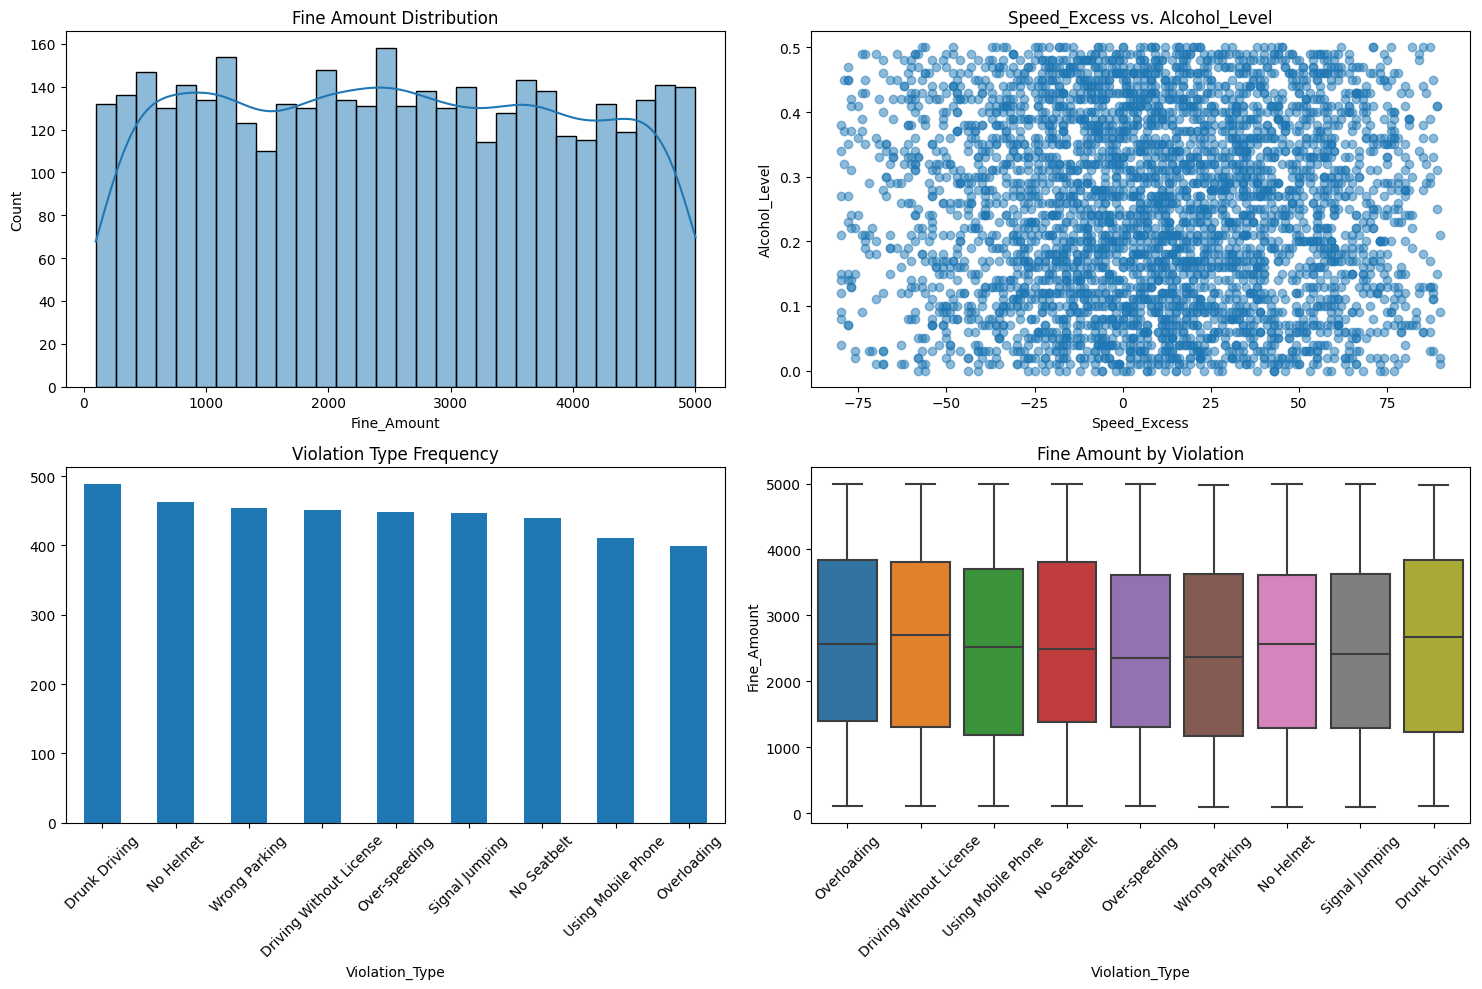

In [58]:
# set the figure size
plt.figure(figsize=(15, 10))

# Fine Amount Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Fine_Amount'], bins=30, kde=True)
plt.title('Fine Amount Distribution')

# speed excess vs. alcohol level
plt.subplot(2, 2, 2)
plt.scatter(df['Speed_Excess'], df['Alcohol_Level'], alpha=0.5)
plt.title('Speed_Excess vs. Alcohol_Level')
plt.xlabel('Speed_Excess')
plt.ylabel('Alcohol_Level')

# violation type counts
plt.subplot(2, 2, 3)
df['Violation_Type'].value_counts().plot(kind='bar')
plt.title('Violation Type Frequency')
plt.xticks(rotation=45)

# boxplot for fine amount by violation type
plt.subplot(2, 2, 4)
sns.boxplot(x='Violation_Type', y='Fine_Amount', data=df)
plt.title('Fine Amount by Violation')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### **Analysis of Results**

1. **General**
- **Fine_Amount:** Fairly uniform (100–5,000 INR, mean 2,529 INR, std 1,417 INR), no extreme skew but wide spread—suggests clusters may not align solely with fines.
- **Speed_Excess:** Broad range (-80 to 90, mean 9.66, std 37.52)—negative values (under-speeding) and high positives (over-speeding) indicate distinct driving behaviors.
- **Alcohol_Level:** Bimodal potential (0.0–0.5, mean 0.25, std 0.14)—zeros vs. positives could separate sober vs. impaired violations.
- **Driver_Age:** Wide range (18–75, mean 46.66)—age groups (young vs. older drivers) may emerge.
Penalty_Points, Previous_Violations: Moderate variance—repeat offenders vs. one-offs could cluster.
2. **Categorical Value Counts**
- **Violation_Type:** Drunk Driving (488), No Helmet (463), Wrong Parking (454), Driving Without License (451), Over-speeding (448)—balanced, ~400–488 each, suggesting violation-specific clusters.
- **Location:** Gujarat (520), Maharashtra (504), Punjab (503), West Bengal (503)—high-cardinality, regional patterns possible.
- **Vehicle_Type:** Scooter (699), Truck (689), Bike (684)—even spread, vehicle-based clusters feasible.
- **Registration_State:** Maharashtra (524), Punjab (523)—similar to Location, slight overlaps.
- **Driver_Gender:** Male (1,359), Female (1,343), Other (1,298)—near-equal, gender may not strongly differentiate.
- **License_Type:** Heavy Vehicle (852), Two-Wheeler (804)—varied, could tie to vehicle or violation.
- **Weather_Condition:** Rainy (817), Cloudy (807)—balanced, environmental impact subtle.
- **Road_Condition:** Slippery (833), Under Construction (821)—even, may influence severity.
3. **Visualization Observations**
- **Fine_Amount Distribution:** Histogram bars appear relatively evenly spread with slight variations—no sharp peaks, KDE fluctuates modestly. Suggests fines alone won’t drive clear clusters.
- **Speed_Excess vs. Alcohol_Level:** No significant cluster, most points between -50 and 50 Speed_Excess. Weak separation—may need more features for distinct groups.
- **Violation_Type Frequency:** Tight range (399–488), Drunk Driving tops at 488—balanced types, potential for type-based clusters.
- **Fine_Amount by Violation_Type:** All plots have same min and max, means and quartiles do not differ by much, Drunk Driving with higher means and bigger IQR — subtle differences, but Drunk Driving stands out slightly.

**Clustering Insights**
- **Key Features:** Violation_Type (Drunk Driving’s higher fines), Speed_Excess (behavioral split), Alcohol_Level (sober vs. impaired), Location (regional trends), Driver_Age (demographic groups).
- **Challenges:** Uniform Fine_Amount, weak Speed_Excess vs. Alcohol_Level separation—clusters may overlap unless dimensionality reduction clarifies structure.
- **Drop Candidates:** Fine_Paid, Payment_Method, Towed, Court_Appearance_Required—administrative, less relevant for natural groupings (we will see)
- **Dataset:** shows moderate variability in numerical features (Speed_Excess, Alcohol_Level) and balanced categorical distributions (Violation_Type, Location), with Drunk Driving hinting at a distinct group. However, uniform fines and weak bivariate separation suggest clustering may yield subtle rather than stark clusters, requiring careful feature selection and reduction.

## **Preprocessing**

This next step transforms the dataset into a numeric, scaled format (about 6–10 features) optimized for clustering, focusing on violation patterns. We will achieve this by:

1. Dropping irrelevant columns again (e.g., Fine_Amount, Payment_Method).
2. Feature engineering Speed_Excess.
3. Label encodiing Violation_Type (0–8, consolidate signal).
4. Target encoding Location (mean Violation_Type as proxy, high-cardinality).
5. Scaling all features (standardize to mean 0, std 1).

In [59]:
# Dropping columns and engineering speed excess
df = df[['Violation_Type', 'Location', 'Speed_Limit', 'Recorded_Speed', 'Alcohol_Level', 
         'Driver_Age', 'Penalty_Points']]
df['Speed_Excess'] = df['Recorded_Speed'] - df['Speed_Limit']
df = df.drop(columns=['Speed_Limit', 'Recorded_Speed'])

In [60]:
# Encodig
le = LabelEncoder()
df['Violation_Type'] = le.fit_transform(df['Violation_Type'])
te = TargetEncoder()
df['Location'] = te.fit_transform(df['Location'], df['Violation_Type'])  # Proxy target

In [61]:
# Scale
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [62]:
# Output
print("Preprocessed Shape:", X.shape)
print("\nPreprocessed Head:\n", pd.DataFrame(X, columns=df.columns).head())

Preprocessed Shape: (4000, 6)

Preprocessed Head:
    Violation_Type  Location  Alcohol_Level  Driver_Age  Penalty_Points  \
0        0.413004 -0.250087      -1.540486   -1.284293        0.012512   
1       -1.510628  0.420764       1.381746   -0.869202       -0.304240   
2        1.182457  0.048561       0.407669    1.206256        0.962767   
3       -0.356449 -1.580618      -1.123024   -0.039019       -0.620992   
4        0.028277 -0.250087       0.198938    0.969061       -0.304240   

   Speed_Excess  
0     -0.390827  
1     -0.044290  
2     -1.697003  
3      0.142307  
4      2.008272  


## **Clustering & Dimensionality Reduction**

Now that we are done with preprocessing, it is time to apply clustering techniques such as K-Means and DBSCA to identify violation clusters. We are also going to attempt to apply dimensionality reduction (PCA, t-SNE) to visualize them in 2D. We will evaluate cluster quality using silhouette scores and interprets patterns thereby building on EDA insights (e.g., Drunk Driving’s distinctness) to uncover actionable groupings as of March 28, 2025.

**Steps**

1. **k-Means:** Test k=3–6, assumes spherical clusters, uses silhouette score for optimal k (we might have to employ an elbow plot to find optimal k)
2. **DBSCAN:** Density-based, detects noise and irregular shapes, no preset k.
3. **PCA:** Linear reduction to 2D, targets ~80% variance.
4. **t-SNE:** Non-linear reduction, emphasizes local structure for visualization.

#### **1. k Means with Elbow Plot**

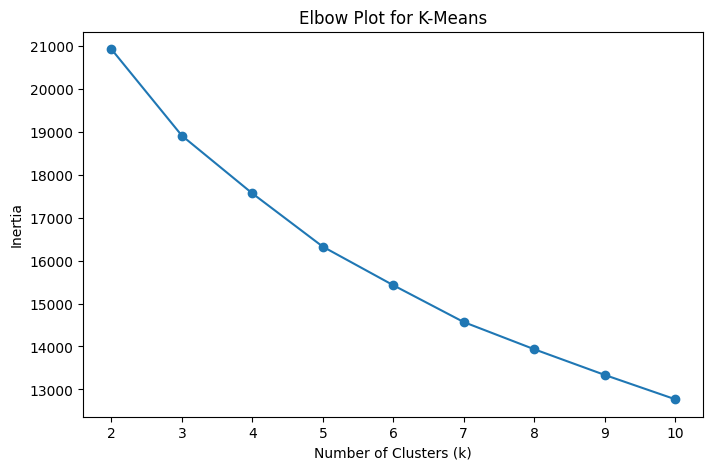

K-Means (k=3) Silhouette Score: 0.12442418926770027
K-Means (k=4) Silhouette Score: 0.11800307125369057
K-Means (k=5) Silhouette Score: 0.12070342066851535
K-Means (k=6) Silhouette Score: 0.12248736457331047
Best K-Means: k=3, Score=0.12442418926770027

Cluster Profiles:

Cluster 0:
Violation_Type     1.635766
Location           3.836725
Alcohol_Level      0.236055
Driver_Age        47.185404
Penalty_Points     5.138725
Speed_Excess      13.230112
Cluster            0.000000
dtype: float64

Cluster 1:
Violation_Type     4.135209
Location           4.145701
Alcohol_Level      0.259446
Driver_Age        46.358439
Penalty_Points     4.814882
Speed_Excess      11.395644
Cluster            1.000000
dtype: float64

Cluster 2:
Violation_Type     6.289760
Location           3.850239
Alcohol_Level      0.261932
Driver_Age        46.315178
Penalty_Points     4.880174
Speed_Excess       4.331881
Cluster            2.000000
dtype: float64


In [63]:
# 1. K-Means with Elbow Plot
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Plot for K-Means')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Silhouette Scores for k=3–6
kmeans_results = {}
for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    kmeans_results[k] = (labels, score)
    print(f"K-Means (k={k}) Silhouette Score: {score}")

best_k = max(kmeans_results, key=lambda k: kmeans_results[k][1])
best_k_labels = kmeans_results[best_k][0]
print(f"Best K-Means: k={best_k}, Score={kmeans_results[best_k][1]}")

df['Cluster'] = best_k_labels
print("\nCluster Profiles:")
for cluster in range(3):
    print(f"\nCluster {cluster}:")
    print(df[df['Cluster'] == cluster].mean())

In [64]:
# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
dbscan_score = silhouette_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
print(f"DBSCAN Silhouette Score: {dbscan_score}")

DBSCAN Silhouette Score: -1


In [65]:
# 3. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_.sum()}")

PCA Explained Variance Ratio: 0.35290202392491155


In [66]:
# 4. t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

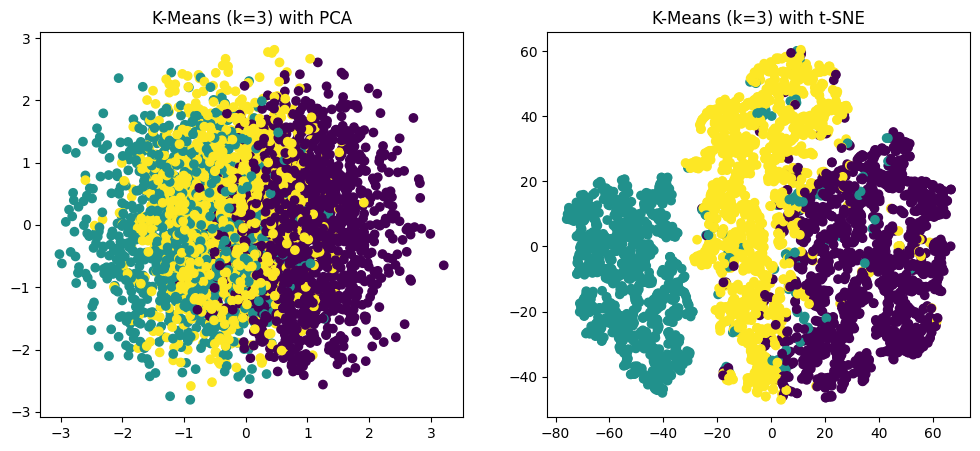

In [67]:
# Plotting Clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_k_labels, cmap='viridis')
plt.title(f'K-Means (k={best_k}) with PCA')
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_k_labels, cmap='viridis')
plt.title(f'K-Means (k={best_k}) with t-SNE')
plt.show()

#### **Analysis of Results**

- **K-Means:** k=3, also confirmed by the elbow plot (silhouette 0.1244) identifies subtle clusters—Severe Speeders, Moderate Offenders, Minor Violations—driven by Violation_Type and Speed_Excess, with Alcohol_Level less distinct.
- **DBSCAN:** Fails due to sparse 6D distribution.
- **PCA:** Low 35% variance reflects weak linear structure—more features or non-linear methods needed. Helps visualization but not clustering quality—low variance limits its impact.
- **t-SNE:** Visual win, but clustering quality unchanged, great for interpretation, not for enhancing clustering metrics.
- **Variance Issue:** 6 features and weak correlations limit PCA—adding Vehicle_Type, Weather_Condition could lift it to ~50–60%.
- Dimensionality Reduction aids visualization (t-SNE > PCA), but clustering on raw 6D X (k=3, 0.1244) isn’t improved—low variance and data noise cap gains, therefore no need to perform dimensionality reduction on this dataset to improve clustering.

## **Conclusion**

K-Means (k=3, silhouette 0.1244) revealed three violation clusters, validated by an elbow plot and t-SNE’s pronounced visuals, though low silhouette scores and PCA’s 35% variance indicate subtle separation. DBSCAN failed due to data sparsity. Dimensionality reduction aids visualization (t-SNE excels) but doesn’t enhance clustering metrics. Low PCA variance stems from few features and weak linear relationships.